<a href="https://colab.research.google.com/github/yezuochen/AI-CUP-2023-Esun/blob/main/Assignments/Term-Project/STAT_DeBERTa_v3_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
!pip install --upgrade kagglehub
import os
import kagglehub
from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# kagglehub.login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.5
    Uninstalling kagglehub-0.3.5:
      Successfully uninstalled kagglehub-0.3.5


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

learning_agency_lab_automated_essay_scoring_2_path = kagglehub.competition_download('learning-agency-lab-automated-essay-scoring-2')
# verracodeguacas_huggingfacedebertav3variants_path = kagglehub.dataset_download('verracodeguacas/huggingfacedebertav3variants')
# cdeotte_deberta_v3_small_finetuned_v1_path = kagglehub.dataset_download('cdeotte/deberta-v3-small-finetuned-v1')
persuade2_path = kagglehub.dataset_download("nbroad/persaude-corpus-2")

print('Data source import complete.')

100%|██████████| 11.9M/11.9M [00:01<00:00, 7.68MB/s]

Extracting files...


100%|██████████| 52.6M/52.6M [00:04<00:00, 12.7MB/s]

Extracting files...


Data source import complete.


This notebook is a fork from Chris Deotte's notebook [DeBERTa-v3-SMALL Starter - [CV 0.820 LB 0.800]](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800)

# DeBERTa-v3-SMALL Regression Starter
This notebook is a fork from Yuto_H's great notebook [here][1]. If you like my notebook, remember to upvote Yuto's notebook too. In this notebook we add the following modifications which are explained in my discussion post [here][3]:
* Change model to `DeBERTa-v3-small` for fast experiments (Note that `xsmall` works well too)
* Increase token `max_length to 1024` (instead of 512 to include all essay text)
* Use total `train batch size = 8`, valid batch size 16 (Note `batch per gpu = 4` and we have 2xT4 GPU)
* Train `4 epochs linear` with start `LR = 1e-5` and `no warmup`
* Remove seed everything (I like randomness)
* Add `QWK metric for regression`
* Add `new tokens` to tokenizer because DeBERTa removes "new paragraph" and "double space" from essay
* `Remove dropout` for regression
* Save `full OOF` predictions
* Add `test inference` and `LB submit`
* Achieves surprising `CV = 0.822` WOW! and LB = ??? (submitting now, let's see what LB is...)

For training, this notebook averages 1 hour per fold which is 15 minutes per epoch training on 2xT4 Kaggle GPU. (Training is done in version 1. And inference and submit to LB is done in version 2).

# Version Notes
In version 1, we finetune a new DeBERTa-v3-SMALL and save it to the Kaggle dataset [here][4]. Therefore if you want to see training epoch details, view notebook version 1. This took 6 hours using Kaggle's 2xT4 GPU.

In notebook version 2, we load the saved fold models and infer test data and submit to LB. Version 2 runs quickly because it is only inference. It will run in either 6 minutes or 1 minute depending on whether we infer OOF and compute CV score again.

If we want version 2 inference to run more quickly, we can set `COMPUTE_CV = False` below, then we will not use 5 minutes to predict OOF and compute CV score. Instead we will only infer test data.

[1]: https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
[2]: https://www.kaggle.com/code/hashidoyuto/deberta-v3-base-aes2-0-infer
[3]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/497832
[4]: https://www.kaggle.com/datasets/cdeotte/deberta-v3-small-finetuned-v1

# Imports and Config
Import libraries and define configuration parameters here.

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# True USES REGRESSION, False USES CLASSIFICATION
USE_REGRESSION = True

# VERSION NUMBER FOR NAMING OF SAVED MODELS
VER=12

# IF "LOAD_FROM" IS None, THEN WE TRAIN NEW MODELS
LOAD_FROM = None #"/kaggle/input/deberta-v3-small-finetuned-v1/"

# WHEN TRAINING NEW MODELS SET COMPUTE_CV = True
# WHEN LOADING MODELS, WE CAN CHOOSE True or False
COMPUTE_CV = True

# True USES PERSUADE 2.0 DATA
USE_PERSUADE2 = True

# True USES THRESHOLD
USE_THRESHOLD = True

import numpy as np
thresholds = np.array([0.8924628856465556,
                       1.7928299320997017,
                       2.5003714130138373,
                       3.131096066363035,
                       3.6488063232574164])

In [4]:
!pip install datasets

import torch
import warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding, DataCollatorForLanguageModeling
from transformers import DebertaV2Tokenizer, DebertaV2ForMaskedLM
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from tokenizers import AddedToken
warnings.simplefilter('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
class PATHS:
    train_path = f'{learning_agency_lab_automated_essay_scoring_2_path}/train.csv'
    test_path = f'{learning_agency_lab_automated_essay_scoring_2_path}/test.csv'
    sub_path = f'{learning_agency_lab_automated_essay_scoring_2_path}/sample_submission.csv'
    per2_path = f"{persuade2_path}/persuade_2.0_human_scores_demo_id_github.csv"
    # model_path = "distilbert-base-uncased"
    # model_path = "microsoft/deberta-v3-small"
    model_path = "microsoft/deberta-v3-base"
    model_name = "microsoft/deberta-v3-base"
    saved_model = "saved_model/stat-deberta-starter-aes2"
    saved_model_name = ""

In [6]:
class CFG:
    n_splits = 5
    seed = 42
    max_length = 1024
    lr = 3e-6 #1e-5
    train_batch_size = 8 #8
    eval_batch_size = 8 #8
    train_epochs = 4 #4
    weight_decay = 0.05 #0.01
    warmup_ratio = 0.0 #0.0
    num_labels = 6
    label_smoothing = 0.1 # add

class per_CFG:
    n_splits = 5
    seed = 42
    max_length = 1024
    lr = 1e-5  # Higher learning rate for pretraining
    train_batch_size = 8  # Larger batch size for external dataset
    eval_batch_size = 8
    train_epochs = 3  # Moderate epochs for pretraining
    weight_decay = 0.05
    warmup_ratio = 0.1  # Adding warmup for smoother training
    num_labels = 6
    label_smoothing = 0.1

In [7]:
def seed_everything(seed):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

#seed_everything(seed=CFG.seed)

# Data Tokenization
We use `max_length = 1024` to avoid truncating majority of essays.

In [8]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid

    def get_dataset(self, df):
        ds = Dataset.from_dict({
                'essay_id': [e for e in df['essay_id']],
                'full_text': [ft for ft in df['full_text']],
                'label': [s for s in df['label']],
            })
        return ds

    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example['full_text'], truncation=True, max_length=CFG.max_length
        )
        return tokenized_inputs

    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)

        tokenized_train = train_ds.map(
            self.tokenize_function, batched=True
        )
        tokenized_valid = valid_ds.map(
            self.tokenize_function, batched=True
        )

        return tokenized_train, tokenized_valid, self.tokenizer

# Compute Metrics
Below we provide compute metric function for both regression and classification. In this notebook we will use regression.

In [9]:
def compute_metrics_for_regression(eval_pred, threshold=USE_THRESHOLD):

    predictions, labels = eval_pred

    if threshold:
        predictions = np.digitize(predictions, thresholds, right=False)

    qwk = cohen_kappa_score(labels, predictions.clip(0,5).round(0), weights='quadratic')
    results = {
        'qwk': qwk
    }
    return results

In [10]:
def compute_metrics_for_classification(eval_pred):

    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights='quadratic')
    results = {
        'qwk': qwk
    }
    return results

# Load Data and Set Fold
For our label, we will use `label = score - 1`. Then the labels will range from 0 to 5. For regression, we convert the label to `float32`. For classification, we would convert to `int32`.

In [11]:
data = pd.read_csv(PATHS.train_path)
data['label'] = data['score'].apply(lambda x: x-1)
if USE_REGRESSION: data["label"] = data["label"].astype('float32')
else: data["label"] = data["label"].astype('int32')

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val_index) in enumerate(skf.split(data, data["score"])):
    data.loc[val_index, "fold"] = i
data.head()

,essay_id,full_text,score,label,fold
0,000d118,Many people have car where they live. The thin...,3,2.0,3.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,2.0,4.0
2,001ab80,People always wish they had the same technolog...,4,3.0,1.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,3.0,0.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2.0,2.0


In [12]:
per2 = pd.read_csv(PATHS.per2_path)
per2["label"] = per2["holistic_essay_score"].apply(lambda x: x-1)
per2.rename(columns={"essay_id_comp": "essay_id"}, inplace=True)
if USE_REGRESSION: per2["label"] = per2["label"].astype('float32')
else: per2["label"] = per2["label"].astype('int32')

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val_index) in enumerate(skf.split(per2, per2["holistic_essay_score"])):
    per2.loc[val_index, "fold"] = i
per2.head(2)

,essay_id,full_text,holistic_essay_score,word_count,prompt_name,task,assignment,source_text,gender,grade_level,ell_status,race_ethnicity,economically_disadvantaged,student_disability_status,label,fold
0,423A1CA112E2,Phones\n\nModern humans today are always on th...,3,378,Phones and driving,Independent,Today the majority of humans own and operate c...,NaN,M,NaN,NaN,Black/African American,NaN,NaN,2.0,1.0
1,BC75783F96E3,This essay will explain if drivers should or s...,4,432,Phones and driving,Independent,Today the majority of humans own and operate c...,NaN,M,NaN,NaN,Black/African American,NaN,NaN,3.0,0.0


In [13]:
per2["prompt_name"].unique()

array(['Phones and driving', 'Car-free cities', 'Summer projects',
       '"A Cowboy Who Rode the Waves"',
       'Mandatory extracurricular activities', 'Exploring Venus',
       'Facial action coding system', 'The Face on Mars',
       'Community service', 'Grades for extracurricular activities',
       'Driverless cars', 'Does the electoral college work?',
       'Cell phones at school', 'Distance learning',
       'Seeking multiple opinions'], dtype=object)

# Set Training Args
We use `fp16=True` which uses mixed precision and uses less GPU VRAM and makes training faster. We use `per_device_train_batch_size = (8 / number of gpus)` because we want total train batch size to be 8. With Kaggle T4, we have 2xT4 GPUs and use `per_device_train_batch_size = 4`.

In [14]:
per_training_args = TrainingArguments(
    output_dir='output_per2',
    fp16=True,  # Use mixed precision for faster training
    learning_rate=per_CFG.lr,
    per_device_train_batch_size=per_CFG.train_batch_size,
    per_device_eval_batch_size=per_CFG.eval_batch_size,
    num_train_epochs=per_CFG.train_epochs,
    weight_decay=per_CFG.weight_decay,
    evaluation_strategy='epoch',  # Evaluate periodically during training
    # eval_steps=500,  # Evaluate every 500 steps
    save_strategy='epoch',
    save_total_limit=1,  # Keep only the best model
    load_best_model_at_end=True,
    warmup_ratio=per_CFG.warmup_ratio,
    lr_scheduler_type='cosine',  # Cosine decay for smoother learning rate adjustments
    logging_steps=100,  # Log every 100 steps
    greater_is_better=False,  # Minimize evaluation loss
    metric_for_best_model='eval_loss',
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,  # Gradient clipping for stability
    report_to='none'  # Disable reporting to external tools
)

training_args = TrainingArguments(
    output_dir=f'output_v{VER}',
    fp16=True,
    learning_rate=CFG.lr,
    per_device_train_batch_size=CFG.train_batch_size,
    per_device_eval_batch_size=CFG.eval_batch_size,
    num_train_epochs=CFG.train_epochs,
    weight_decay=CFG.weight_decay,
    evaluation_strategy='epoch',
    metric_for_best_model='eval_loss', #qwk
    greater_is_better=False,
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to='none',
    warmup_ratio=CFG.warmup_ratio,
    lr_scheduler_type='linear', # "cosine" or "linear" or "constant"
    # optim='adamw_torch',
    logging_first_step=True,
    gradient_accumulation_steps=1, # add
    # lr_scheduler_type='reduce_lr_on_plateau', # add
    max_grad_norm=0
)

In [15]:
# Assuming 'train_df' is your training DataFrame and 'labels' is the column with class labels
class_labels = data['label']
classes = np.unique(class_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=class_labels
)

# Create a dictionary mapping class indices to weights
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print("Class Weights:", class_weights_dict)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
class_weights_tensor = class_weights_tensor + class_weights_tensor.max()

Class Weights: {0.0: 2.3039137380191694, 1.0: 0.6107347025195851, 2.0: 0.45931528662420384, 3.0: 0.7347172694854814, 4.0: 2.9737113402061857, 5.0: 18.490384615384617}


In [16]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Define the loss function with class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor,
                                             label_smoothing=CFG.label_smoothing).to(logits.device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# K Fold Training
We add new tokens for ("\n") new paragraph and (" "*2) double space because the default DeBERTa tokenizer removes these but these are helpful for scoring essays. We remove dropout from our model because this does not work well when using regression. Read discussion [here][1]

[1]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/497832

In [17]:
if USE_PERSUADE2:
    tokenizer = AutoTokenizer.from_pretrained(PATHS.model_path)
    tokenizer.add_tokens([AddedToken("\n", normalized=False)])
    tokenizer.add_tokens([AddedToken(" "*2, normalized=False)])
    tokenize = Tokenize(per2, per2, tokenizer)
    tokenized_per2, _, _ = tokenize()

    config = AutoConfig.from_pretrained(PATHS.model_path)
    config.max_position_embeddings = CFG.max_length

    if USE_REGRESSION:
        config.attention_probs_dropout_prob = 0.3
        config.hidden_dropout_prob = 0.3
        config.num_labels = 1
        config.problem_type = "regression"
    else:
        config.num_labels = CFG.num_labels
        config.hidden_dropout_prob = 0.3
        config.attention_probs_dropout_prob = 0.3

    model = AutoModelForSequenceClassification.from_pretrained(PATHS.model_path, config=config)
    model.resize_token_embeddings(len(tokenizer))

    # model = DebertaV2ForMaskedLM.from_pretrained(PATHS.model_name, config=config)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    if USE_REGRESSION: compute_metrics = compute_metrics_for_regression
    else: compute_metrics = compute_metrics_for_classification

    # per2_args = training_args.to_dict()
    # per2_args = TrainingArguments(**per2_args)
    trainer = Trainer(
        model=model,
        args=per_training_args,
        train_dataset=tokenized_per2,
        eval_dataset=tokenized_per2,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    if LOAD_FROM is None:
        trainer.train()
        trainer.save_model(f"model-per2-trained")
        tokenizer.save_pretrained(f"model-per2-trained")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/25996 [00:00<?, ? examples/s]

Map:   0%|          | 0/25996 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Qwk
1,0.324800,0.419941,0.789319


Epoch,Training Loss,Validation Loss,Qwk
1,0.324800,0.419941,0.789319
2,0.313200,0.400377,0.793123
3,0.279600,0.374738,0.800852


In [18]:
# kagglehub.login()

# kagglehub.dataset_upload("yezuochen/stat-deberta-small-aes2-reg-per2", "/content/model-persuade2-trained", "only with persuade 2.0")
# kagglehub.dataset_upload("yezuochen/stat-deberta-aes2-per2", "/content/model-persuade2-trained", "only with persuade 2.0")

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = '/content/model-per2-trained'

MODEL_SLUG = 'stat-deberta-per2' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"yezuochen/{MODEL_SLUG}/transformers/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = 'Update 2024-12-22')

Uploading Model https://www.kaggle.com/models/yezuochen/stat-deberta-per2/transformers/default ...
Starting upload for file /content/model-per2-trained/tokenizer.json


Uploading: 100%|██████████| 8.66M/8.66M [00:02<00:00, 3.29MB/s]

Upload successful: /content/model-per2-trained/tokenizer.json (8MB)
Starting upload for file /content/model-per2-trained/tokenizer_config.json



Uploading: 100%|██████████| 1.66k/1.66k [00:01<00:00, 967B/s]

Upload successful: /content/model-per2-trained/tokenizer_config.json (2KB)
Starting upload for file /content/model-per2-trained/model.safetensors



Uploading: 100%|██████████| 737M/737M [00:32<00:00, 22.9MB/s]

Upload successful: /content/model-per2-trained/model.safetensors (703MB)
Starting upload for file /content/model-per2-trained/training_args.bin



Uploading: 100%|██████████| 5.30k/5.30k [00:01<00:00, 3.15kB/s]

Upload successful: /content/model-per2-trained/training_args.bin (5KB)
Starting upload for file /content/model-per2-trained/special_tokens_map.json



Uploading: 100%|██████████| 286/286 [00:00<00:00, 294B/s]

Upload successful: /content/model-per2-trained/special_tokens_map.json (286B)
Starting upload for file /content/model-per2-trained/config.json



Uploading: 100%|██████████| 1.01k/1.01k [00:01<00:00, 593B/s]

Upload successful: /content/model-per2-trained/config.json (1009B)
Starting upload for file /content/model-per2-trained/added_tokens.json



Uploading: 100%|██████████| 55.0/55.0 [00:01<00:00, 31.8B/s]

Upload successful: /content/model-per2-trained/added_tokens.json (55B)
Starting upload for file /content/model-per2-trained/spm.model



Uploading: 100%|██████████| 2.46M/2.46M [00:03<00:00, 771kB/s] 

Upload successful: /content/model-per2-trained/spm.model (2MB)


Your model instance version has been created.
Files are being processed...
See at: https://www.kaggle.com/models/yezuochen/stat-deberta-per2/transformers/default


Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Qwk
1,0.304900,0.361492,0.788172
2,0.285100,0.412200,0.772487
3,0.280900,0.415134,0.771222
4,0.267300,0.403344,0.773597


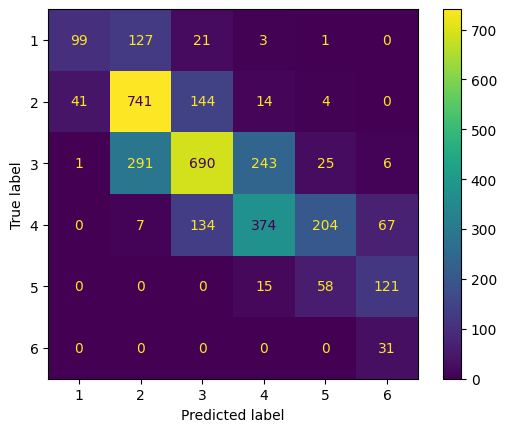

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Qwk
1,0.291800,0.553542,0.719998
2,0.280800,0.385659,0.781712
3,0.278400,0.388626,0.776989
4,0.256700,0.390186,0.779914


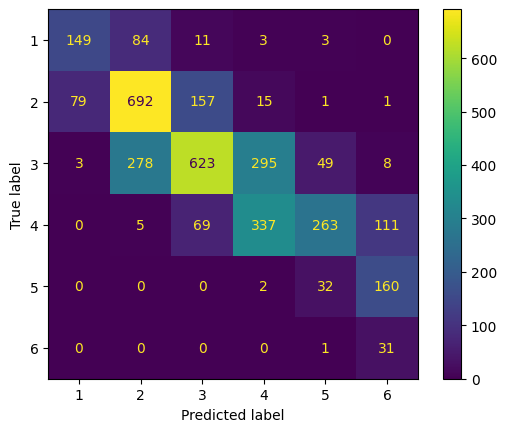

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Qwk
1,0.298900,0.423358,0.774177
2,0.322600,0.475378,0.753745
3,0.283200,0.523226,0.735781
4,0.273400,0.450189,0.758833


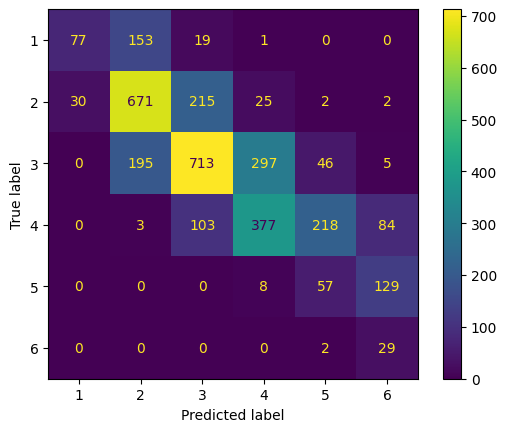

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Qwk
1,0.303600,0.452223,0.751097
2,0.271700,0.398300,0.769755
3,0.276300,0.359445,0.785956
4,0.266200,0.375378,0.778711


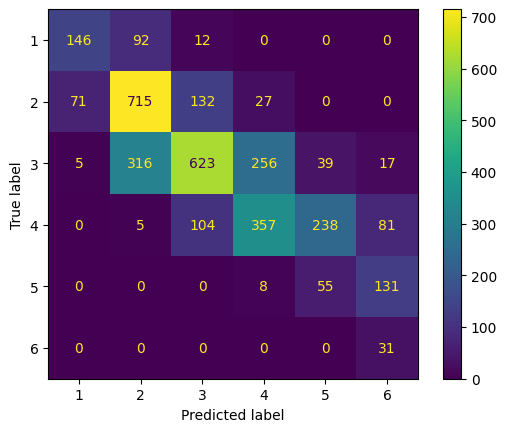

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Qwk
1,0.298800,0.396400,0.776017
2,0.291700,0.401137,0.773134
3,0.279300,0.435962,0.761745
4,0.260700,0.400547,0.773923


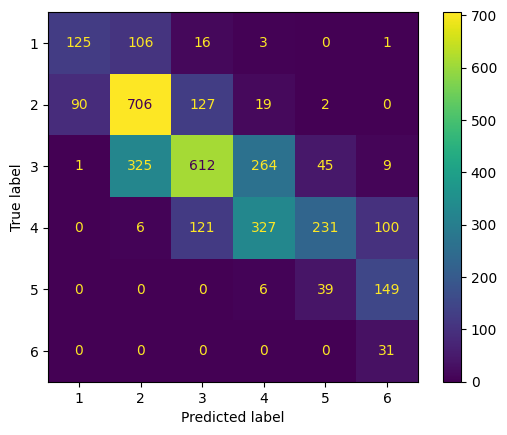

In [19]:
if COMPUTE_CV:
    for fold in range(len(data['fold'].unique())):

        # GET TRAIN AND VALID DATA
        train = data[data['fold'] != fold]
        valid = data[data['fold'] == fold].copy()

        # ADD NEW TOKENS for ("\n") new paragraph and (" "*2) double space
        if USE_PERSUADE2:
            tokenizer = AutoTokenizer.from_pretrained(f"model-per2-trained")
        else:
            tokenizer = AutoTokenizer.from_pretrained(PATHS.model_path)
            tokenizer.add_tokens([AddedToken("\n", normalized=False)])
            tokenizer.add_tokens([AddedToken(" "*2, normalized=False)])


        tokenize = Tokenize(train, valid, tokenizer)
        tokenized_train, tokenized_valid, _ = tokenize()

        # REMOVE DROPOUT FROM REGRESSION
        config = AutoConfig.from_pretrained(PATHS.model_path)
        config.max_position_embeddings = CFG.max_length

        if USE_REGRESSION:
            config.attention_probs_dropout_prob = 0.3
            config.hidden_dropout_prob = 0.3
            config.num_labels = 1
            config.problem_type = "regression"
        else:
            config.num_labels = CFG.num_labels
            config.hidden_dropout_prob = 0.3
            config.attention_probs_dropout_prob = 0.3

        if LOAD_FROM:
            model = AutoModelForSequenceClassification.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
        elif USE_PERSUADE2:
            model = AutoModelForSequenceClassification.from_pretrained(f"model-per2-trained")
        else:
            model = AutoModelForSequenceClassification.from_pretrained(PATHS.model_path, config=config)
            model.resize_token_embeddings(len(tokenizer))

            # model = DebertaV2ForMaskedLM.from_pretrained(PATHS.model_name)



        # TRAIN WITH TRAINER
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        # data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15, return_tensors="pt")
        if USE_REGRESSION: compute_metrics = compute_metrics_for_regression
        else: compute_metrics = compute_metrics_for_classification
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_valid,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )
        if LOAD_FROM is None:
            trainer.train()

        # PLOT CONFUSION MATRIX
        y_true = valid['score'].values
        predictions0 = trainer.predict(tokenized_valid).predictions
        if USE_THRESHOLD: predictions0 = np.digitize(predictions0, thresholds, right=False)
        if USE_REGRESSION: predictions = predictions0.round(0) + 1
        else: predictions = predictions0.argmax(axis=1) + 1
        cm = confusion_matrix(y_true, predictions, labels=[x for x in range(1,7)])
        draw_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        draw_cm.plot()
        plt.show()

        # SAVE FOLD MODEL AND TOKENIZER
        if LOAD_FROM is None:
            trainer.save_model(f'{PATHS.saved_model}_fold_{fold}_v{VER}')
            tokenizer.save_pretrained(f'{PATHS.saved_model}_fold_{fold}_v{VER}')

        # SAVE OOF PREDICTIONS
        if USE_REGRESSION:
            valid['pred'] = predictions0 + 1
        else:
            COLS = [f'p{x}' for x in range(CFG.num_labels)]
            valid[COLS] = predictions0
        valid.to_csv(f'valid_df_fold_{fold}_v{VER}.csv', index=False)

In [20]:
import kagglehub

# kagglehub.login()

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = '/content/saved_model'

MODEL_SLUG = 'stat-deberta-aes' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"yezuochen/{MODEL_SLUG}/transformers/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = 'Update 2024-12-22')

Uploading Model https://www.kaggle.com/models/yezuochen/stat-deberta-aes/transformers/default ...
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/tokenizer.json


Uploading: 100%|██████████| 8.65M/8.65M [00:02<00:00, 3.23MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/tokenizer.json (8MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/tokenizer_config.json



Uploading: 100%|██████████| 1.76k/1.76k [00:00<00:00, 1.87kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/tokenizer_config.json (2KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/model.safetensors



Uploading: 100%|██████████| 737M/737M [00:33<00:00, 22.3MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/model.safetensors (703MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/training_args.bin



Uploading: 100%|██████████| 5.30k/5.30k [00:01<00:00, 3.01kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/training_args.bin (5KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/special_tokens_map.json



Uploading: 100%|██████████| 970/970 [00:01<00:00, 547B/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/special_tokens_map.json (970B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/config.json



Uploading: 100%|██████████| 1.00k/1.00k [00:00<00:00, 1.28kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/config.json (1002B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/added_tokens.json



Uploading: 100%|██████████| 55.0/55.0 [00:00<00:00, 74.4B/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/added_tokens.json (55B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/spm.model



Uploading: 100%|██████████| 2.46M/2.46M [00:03<00:00, 774kB/s] 

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_4_v12/spm.model (2MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/tokenizer.json



Uploading: 100%|██████████| 8.65M/8.65M [00:03<00:00, 2.53MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/tokenizer.json (8MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/tokenizer_config.json



Uploading: 100%|██████████| 1.76k/1.76k [00:01<00:00, 1.03kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/tokenizer_config.json (2KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/model.safetensors



Uploading: 100%|██████████| 737M/737M [00:33<00:00, 22.2MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/model.safetensors (703MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/training_args.bin



Uploading: 100%|██████████| 5.30k/5.30k [00:01<00:00, 3.06kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/training_args.bin (5KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/special_tokens_map.json



Uploading: 100%|██████████| 970/970 [00:00<00:00, 1.25kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/special_tokens_map.json (970B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/config.json



Uploading: 100%|██████████| 1.00k/1.00k [00:00<00:00, 1.04kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/config.json (1002B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/added_tokens.json



Uploading: 100%|██████████| 55.0/55.0 [00:00<00:00, 70.3B/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/added_tokens.json (55B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/spm.model



Uploading: 100%|██████████| 2.46M/2.46M [00:03<00:00, 788kB/s] 

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_0_v12/spm.model (2MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/tokenizer.json



Uploading: 100%|██████████| 8.65M/8.65M [00:02<00:00, 3.17MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/tokenizer.json (8MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/tokenizer_config.json



Uploading: 100%|██████████| 1.76k/1.76k [00:00<00:00, 2.00kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/tokenizer_config.json (2KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/model.safetensors



Uploading: 100%|██████████| 737M/737M [00:32<00:00, 22.9MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/model.safetensors (703MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/training_args.bin



Uploading: 100%|██████████| 5.30k/5.30k [00:01<00:00, 3.08kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/training_args.bin (5KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/special_tokens_map.json



Uploading: 100%|██████████| 970/970 [00:01<00:00, 575B/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/special_tokens_map.json (970B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/config.json



Uploading: 100%|██████████| 1.00k/1.00k [00:01<00:00, 575B/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/config.json (1002B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/added_tokens.json



Uploading: 100%|██████████| 55.0/55.0 [00:01<00:00, 32.7B/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/added_tokens.json (55B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/spm.model



Uploading: 100%|██████████| 2.46M/2.46M [00:03<00:00, 792kB/s] 

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_1_v12/spm.model (2MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/tokenizer.json



Uploading: 100%|██████████| 8.65M/8.65M [00:03<00:00, 2.47MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/tokenizer.json (8MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/tokenizer_config.json



Uploading: 100%|██████████| 1.76k/1.76k [00:01<00:00, 1.05kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/tokenizer_config.json (2KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/model.safetensors



Uploading: 100%|██████████| 737M/737M [00:32<00:00, 22.6MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/model.safetensors (703MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/training_args.bin



Uploading: 100%|██████████| 5.30k/5.30k [00:00<00:00, 5.85kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/training_args.bin (5KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/special_tokens_map.json



Uploading: 100%|██████████| 970/970 [00:01<00:00, 572B/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/special_tokens_map.json (970B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/config.json



Uploading: 100%|██████████| 1.00k/1.00k [00:00<00:00, 1.09kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/config.json (1002B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/added_tokens.json



Uploading: 100%|██████████| 55.0/55.0 [00:01<00:00, 31.4B/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/added_tokens.json (55B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/spm.model



Uploading: 100%|██████████| 2.46M/2.46M [00:02<00:00, 1.11MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_3_v12/spm.model (2MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/tokenizer.json



Uploading: 100%|██████████| 8.65M/8.65M [00:02<00:00, 3.44MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/tokenizer.json (8MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/tokenizer_config.json



Uploading: 100%|██████████| 1.76k/1.76k [00:01<00:00, 1.02kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/tokenizer_config.json (2KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/model.safetensors



Uploading: 100%|██████████| 737M/737M [00:32<00:00, 23.0MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/model.safetensors (703MB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/training_args.bin



Uploading: 100%|██████████| 5.30k/5.30k [00:00<00:00, 6.87kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/training_args.bin (5KB)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/special_tokens_map.json



Uploading: 100%|██████████| 970/970 [00:00<00:00, 1.27kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/special_tokens_map.json (970B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/config.json



Uploading: 100%|██████████| 1.00k/1.00k [00:00<00:00, 1.31kB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/config.json (1002B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/added_tokens.json



Uploading: 100%|██████████| 55.0/55.0 [00:01<00:00, 32.5B/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/added_tokens.json (55B)
Starting upload for file /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/spm.model



Uploading: 100%|██████████| 2.46M/2.46M [00:02<00:00, 1.10MB/s]

Upload successful: /content/saved_model/stat-deberta-starter-aes2_fold_2_v12/spm.model (2MB)


BackendError: The file count exceeds the maximum of 25

# Overall CV Score

In [ ]:
if COMPUTE_CV:
    dfs = []
    for k in range(CFG.n_splits):
        dfs.append( pd.read_csv(f'valid_df_fold_{k}_v{VER}.csv') )
        os.system(f'rm valid_df_fold_{k}_v{VER}.csv')
    dfs = pd.concat(dfs)
    dfs.to_csv(f'valid_df_v{VER}.csv',index=False)
    print('Valid OOF shape:', dfs.shape )
    display( dfs.head() )

In [ ]:
if COMPUTE_CV:
    if USE_REGRESSION:
        m = cohen_kappa_score(dfs.score.values, dfs.pred.values.clip(1,6).round(0), weights='quadratic')
    else:
        m = cohen_kappa_score(dfs.score.values, dfs.iloc[:,-6:].values.argmax(axis=1)+1, weights='quadratic')
    print('Overall QWK CV =',m)

# Infer Test Data
We infer test data using Hugging Face trainer and load our saved best fold models.

In [ ]:
test = pd.read_csv(PATHS.test_path)
print('Test shape:', test.shape)
test.head()

In [ ]:
from datasets import Value

all_pred = []
test['label'] = 0.0

for fold in range(CFG.n_splits):

    # LOAD TOKENIZER
    if LOAD_FROM:
        tokenizer = AutoTokenizer.from_pretrained(LOAD_FROM + f'{PATHS.saved_model}_fold_{fold}_v{VER}')
    else:
        tokenizer = AutoTokenizer.from_pretrained(f'{PATHS.saved_model}_fold_{fold}_v{VER}')
    tokenize = Tokenize(test, test, tokenizer)
    tokenized_test, _, _ = tokenize()

    # LOAD MODEL
    if LOAD_FROM:
        model = AutoModelForSequenceClassification.from_pretrained(LOAD_FROM + f'{PATHS.saved_model}_fold_{fold}_v{VER}')
    else:
        model = AutoModelForSequenceClassification.from_pretrained(f'{PATHS.saved_model}_fold_{fold}_v{VER}')

    # INFER WITH TRAINER
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    testing_args = training_args
    testing_args.eval_strategy = "no"
    if not USE_REGRESSION:
      tokenized_test = tokenized_test.cast_column('label', Value('int32'))
    print(tokenized_test["label"])
    trainer = Trainer(
        model=model,
        args=testing_args,
        train_dataset=tokenized_test,
        # eval_dataset=tokenized_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    # SAVE PREDICTIONS
    predictions = trainer.predict(tokenized_test).predictions
    all_pred.append( predictions )

In [ ]:
preds = np.mean(all_pred, axis=0)
print('Predictions shape:',preds.shape)

# Create Submission CSV

In [ ]:
sub = pd.read_csv(PATHS.sub_path)
if USE_THRESHOLD: preds = np.digitize(preds, thresholds, right=False)
if USE_REGRESSION: sub["score"] = preds.clip(0,5).round(0)+1
else: sub["score"] = preds.argmax(axis=1)+1
sub.score = sub.score.astype('int32')
sub.to_csv('submission.csv',index=False)
print('Submission shape:', sub.shape )
sub.head()

In [ ]:
# import zipfile

# def zipdir(path, zip_file_path):
#     with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#         for root, dirs, files in os.walk(path):
#             for file in files:
#                 zipf.write(os.path.join(root, file),
#                            os.path.relpath(os.path.join(root, file),
#                                            os.path.join(path, '..')))

# zipdir('saved_model', 'stat-deberta-aes2-py.zip')

In [ ]:
# !zip -r stat-deberta-aes2.zip saved_model

In [ ]:
from google.colab import runtime
runtime.unassign()